In [1]:
# functional connectivity analysis of the PREK movie-watching paradigm

# define output directory
out_dir = '/mnt/disks/yeatman-scratch/PREK_bids/fc_analysis/func_conn_atlas/harvard_oxford'
# fmriprep directory
func_dir ='/mnt/disks/yeatman-scratch/PREK_bids/derivatives/fmriprep'

subj = ['1103', '1110', '1112', '1113', '1184', '1208', '1210', '1241', '1262','1271', '1293', '1302','1372','1382','1391','1401','1443','1460','1490','1505','1673','1676','1691','1706','1714','1715','1750','1751','1756','1762','1768','1790','1798','1812','1818','1868','1869','1878','1887','1901','1916','1921','1936','1939','1940','1951','1964','1966']


/home/ilianak/anaconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/ilianak/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


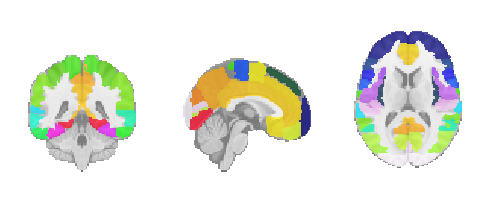

In [2]:
from nilearn import datasets
# retrieve the Harvard-Oxford cortical parcellation, sampled at 2mm, with a threshold of a probability of 0.25
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

atlas_filename = dataset.maps
labels = dataset.labels

# ALTERNATIVE: define costum atlas
# atlas_filename = '/mnt/disks/yeatman-scratch/PREK_bids/fc_analysis/func_conn_atlas/Gordon_atlas/Parcels_MNI_222.nii'

from nilearn import plotting
plotting.plot_roi(atlas_filename, draw_cross=False, annotate=False)

In [7]:
import pandas as pd
import numpy as np

for i in range(len(subj)):
    
    print('Working on subject ' + subj[i])
    
    ses = ['pre','post']
    run = ['1', '2']
    
    for s in range(len(ses)):
        # select correct files in case of more or less than 2 runs
        if subj[i]=='1262' and ses[s]=='post':
            run = ['1', '3']
        elif subj[i]=='1706' and ses[s]=='post':
            run = ['1']
        elif subj[i]=='1921' and ses[s]=='post':
            run = ['2', '3']
        elif subj[i]=='1966' and ses[s]=='post':
            run = ['2', '3']
        
        
        for r in range(len(run)):
            # get confound file
            conf = pd.read_csv(func_dir + '/sub-' + subj[i] + '/ses-' + ses[s] + '/func/sub-' + subj[i] + '_ses-' + ses[s] + '_task-movie_run-' + run[r] + '_desc-confounds_timeseries.tsv', sep = '\t') 

            fd = conf[['framewise_displacement']]
            fd = fd.fillna(0)
            #fd_diff = fd.diff(axis=0);
            
            # create scrub regressor to flag volumes with FD>0.9mm
            scrub = np.zeros((len(fd), 1))
            scrub = np.where(fd < 0.9, 0, 1)
            # scrub first scan
            scrub[0]=1
            
            # select confounds
            conf = conf[['csf', 'white_matter','trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
            conf['scrub'] = scrub
            conf = conf.fillna(0)
            
            # only analyze runs with <10% of censored volumes (max 9 volumes of a total of 98) 
            if sum(scrub)<10:
                
                print('Computing functional connectivity, session ' + ses[s] + ', run ' + run[r])

                # get the fMRI data            
                func_filename = (func_dir + '/sub-' + subj[i] + '/ses-' + ses[s] + '/func/sub-' + subj[i] + '_ses-' + ses[s] + '_task-movie_run-' + run[r] + '_space-MNIPediatricAsym_cohort-1_desc-preproc_bold.nii.gz')
                
                # extract signal from parcellation
                from nilearn.input_data import NiftiLabelsMasker
                masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, memory='nilearn_cache')
                time_series = masker.fit_transform(func_filename, confounds=[conf])
                
                # compute correlation matrix
                from nilearn.connectome import ConnectivityMeasure
                correlation_measure = ConnectivityMeasure(kind='correlation')
                correlation_matrix = correlation_measure.fit_transform([time_series])[0]
                
                #save correlation matrix to txt file
                np.savetxt(out_dir + '/sub-' + subj[i] + '_ses-' + ses[s] + '_task-movie_run-' + run[r] + '_corr_matrix', correlation_matrix)
                    
            else:
                print('Excluding session ' + ses[s] + ', run ' + run[r])

Working on subject 1103
Computing functional connectivity, session pre, run 1
Computing functional connectivity, session pre, run 2
Computing functional connectivity, session post, run 1
Computing functional connectivity, session post, run 2
Working on subject 1110
Computing functional connectivity, session pre, run 1
Computing functional connectivity, session pre, run 2
Computing functional connectivity, session post, run 1
Computing functional connectivity, session post, run 2
Working on subject 1112
Computing functional connectivity, session pre, run 1
Computing functional connectivity, session pre, run 2
Computing functional connectivity, session post, run 1
Computing functional connectivity, session post, run 2
Working on subject 1113
Computing functional connectivity, session pre, run 1
Computing functional connectivity, session pre, run 2
Excluding session post, run 1
Excluding session post, run 2
Working on subject 1184
Computing functional connectivity, session pre, run 1
Excl

Working on subject 1869
Computing functional connectivity, session pre, run 1
Computing functional connectivity, session pre, run 2
Computing functional connectivity, session post, run 1
Computing functional connectivity, session post, run 2
Working on subject 1878
Computing functional connectivity, session pre, run 1
Excluding session pre, run 2
Computing functional connectivity, session post, run 1
Computing functional connectivity, session post, run 2
Working on subject 1887
Computing functional connectivity, session pre, run 1
Computing functional connectivity, session pre, run 2
Computing functional connectivity, session post, run 1
Computing functional connectivity, session post, run 2
Working on subject 1901
Computing functional connectivity, session pre, run 1
Computing functional connectivity, session pre, run 2
Computing functional connectivity, session post, run 1
Computing functional connectivity, session post, run 2
Working on subject 1916
Computing functional connectivity

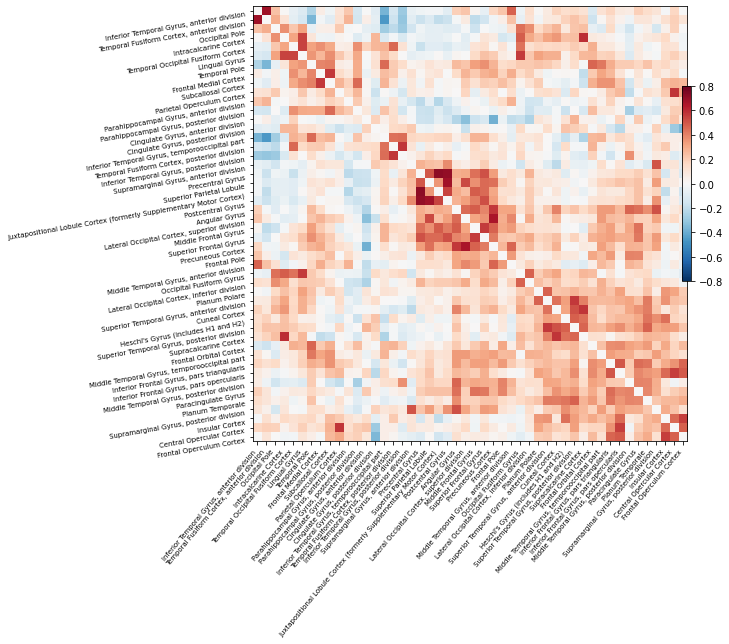

In [10]:
# Plot the correlation matrix
import numpy as np
from nilearn import plotting

subj='1113'
ses='pre'
run='2'

correlation_matrix = np.loadtxt(out_dir + '/sub-' + subj + '_ses-' + ses + '_task-movie_run-' + run + '_corr_matrix')


# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)